# **Ejercicio 3: Análisis de sentimientos en reseñas de productos**

**Descripción del problema**

El objetivo del proyecto es desarrollar un modelo de aprendizaje supervisado que sea capaz de clasificar de forma automática las reseñas de productos como positivas o negativas, usando sólo el texto de los reviews compartidos por los usuarios.

Para ello se utiliza un dataset real proveniente de Amazon, compuesto por millones de reseñas de clientes junto con su calificación en estrellas. En el conjunto de datos, las reseñas han sido preprocesadas siguiendo el formato utilizado por la librería fastText:

**__label__1** → reseñas negativas (1 y 2 estrellas)

**__label__2**→ reseñas positivas (4 y 5 estrellas)

Cada fila incluye el título de la reseña seguido del contenido principal, lo que permite trabajar con texto más descriptivo y realista. Aunque la mayoría de los textos están en inglés, también existen algunos ejemplos en otros idiomas como español.


A lo largo del ejercicio se van a llevar a cabo:

* Exploración y limpieza del texto, preparando los datos para su uso por modelos de Machine Learning.

* Vectorización de los textos utilizando representaciones numéricas (TF-IDF).

* Entrenamiento de tres modelos supervisados para comparar su desempeño.

* Evaluación mediante métricas apropiadas como precisión, recall, F1-score o ROC-AUC.

* Visualización de resultados y análisis final de desempeño.

El objetivo final será identificar qué modelo nos puede ofrecer la mejor capacidad de clasificación sobre este conjunto de datos reales y de alta escala.

In [1]:
#Se instala Kagglehub para el dataset, se hacen los imports y la configuración
!pip -q install kagglehub
import os
import bz2
import re
from collections import Counter

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle

# Descargas necesarias de NLTK (solo la primera vez)
nltk.download("stopwords")
nltk.download("wordnet")

plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams["axes.grid"] = True




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Se descarga el dataset de Kaggle a una carpeta local de cache
root = kagglehub.dataset_download("bittlingmayer/amazonreviews")
root

Using Colab cache for faster access to the 'amazonreviews' dataset.


'/kaggle/input/amazonreviews'

In [3]:
#Se traen las rutas de los archivos
train_path = os.path.join(root, "train.ft.txt.bz2")
test_path  = os.path.join(root, "test.ft.txt.bz2")
train_path, test_path

#Implementación de la función para poder leer los .bz2
def cargar_fasttext_bz2(path, max_lines=None):
    """
    Lee un archivo .bz2 del formato fastText:
    __label__1 texto...
    __label__2 texto...

    Devuelve una lista de [label_binaria, texto].

    max_lines: si es None, lee todo el archivo.
               si es un número, solo lee ese número de líneas (útil para pruebas).
    """
    data = []
    with bz2.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue

            label_raw, text = line.split(" ", 1)
            # __label__2 = positiva (1), __label__1 = negativa (0)
            label = 1 if label_raw == "__label__2" else 0
            data.append([label, text])
    return data

In [4]:
# Se carga el data set completo

#se usa max_lines=None para el dataset completo
train_data = cargar_fasttext_bz2(train_path, max_lines=None)
test_data  = cargar_fasttext_bz2(test_path,  max_lines=None)

# Unimos train + test
all_data = train_data + test_data

df = pd.DataFrame(all_data, columns=["label", "reviewText"])
df.head(), df.shape

(   label                                         reviewText
 0      1  Stuning even for the non-gamer: This sound tra...
 1      1  The best soundtrack ever to anything.: I'm rea...
 2      1  Amazing!: This soundtrack is my favorite music...
 3      1  Excellent Soundtrack: I truly like this soundt...
 4      1  Remember, Pull Your Jaw Off The Floor After He...,
 (4000000, 2))

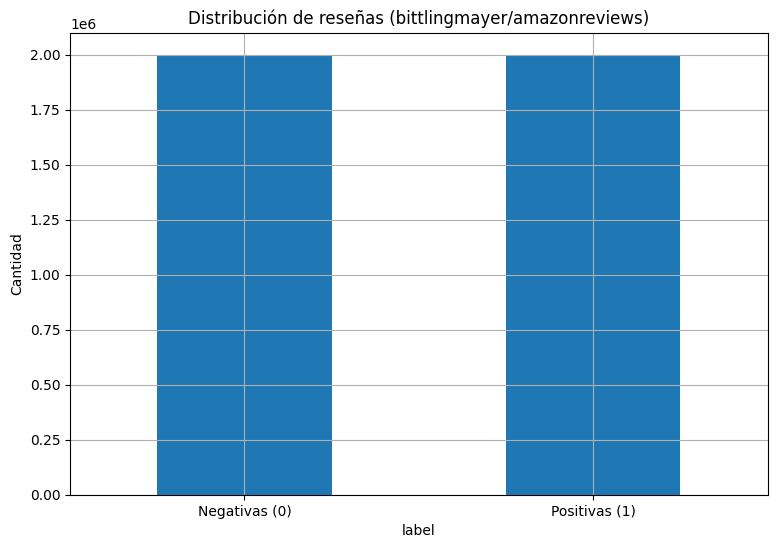

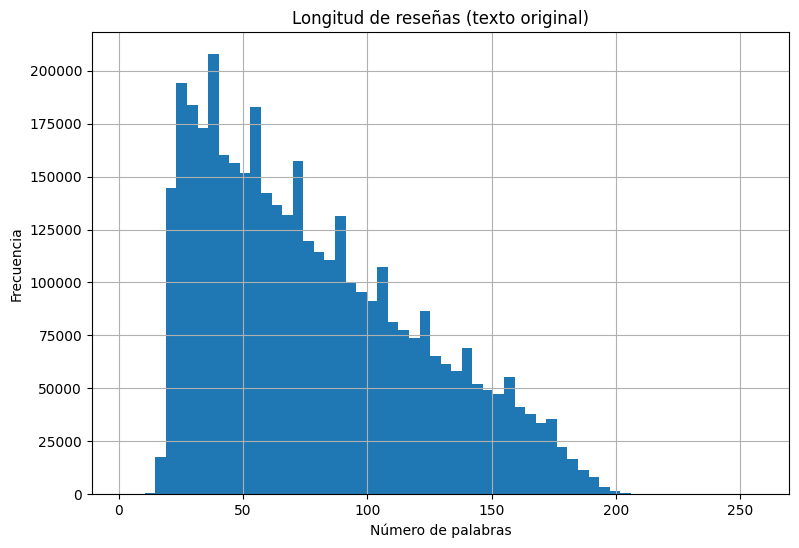

In [5]:
#Se implementa el EDA basico

# Distribución de opiniones
df["label"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["Negativas (0)", "Positivas (1)"], rotation=0)
plt.title("Distribución de reseñas (bittlingmayer/amazonreviews)")
plt.ylabel("Cantidad")
plt.show()

# Longitud en número de palabras (sin limpiar)
df["raw_length"] = df["reviewText"].apply(lambda x: len(str(x).split()))
df["raw_length"].hist(bins=60)
plt.title("Longitud de reseñas (texto original)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

In [6]:
#Se organizan las stopwords

stop_words = set(stopwords.words("english"))

# Palabras que deben conservarse para detectar negatividad
negation_words = {
    "not", "no", "never",
    "nothing", "nowhere", "none",
    "cannot", "can't", "dont", "don't",
    "isnt", "isn't", "wasnt", "wasn't",
    "shouldnt", "shouldn't", "couldnt", "couldn't"
}

# Quitamos las palabras negativas de las stopwords
stop_words = stop_words.difference(negation_words)

stop_words = list(stop_words)

In [7]:
#Se hace la limpieza y normalización

lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-zA-Z']", " ", texto)   # conservar apóstrofes: isn't, don't

    tokens = texto.split()

    # quitar solo stopwords que NO sean palabras negativas
    tokens = [t for t in tokens if t not in stop_words]

    # lematización simple
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

df["clean_text"] = df["reviewText"].astype(str).apply(limpiar_texto)
df["length"] = df["clean_text"].apply(lambda x: len(x.split()))
df[["reviewText","clean_text","length"]].head()

,reviewText,clean_text,length
0,Stuning even for the non-gamer: This sound tra...,stuning even non gamer sound track beautiful p...,44
1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything reading lot revi...,46
2,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hand in...,69
3,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...,75
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing played game kn...,46


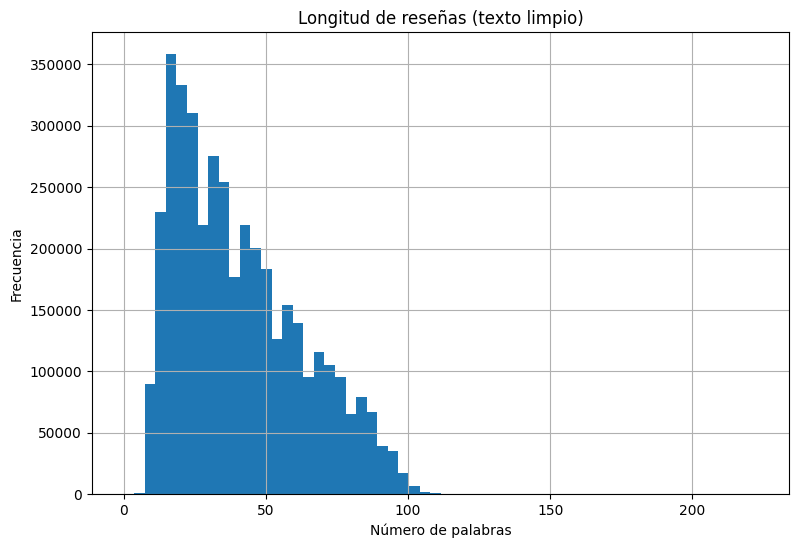

In [8]:
#Se tiene el EDA depurado (longitud + distribución)
df["length"].hist(bins=60)
plt.title("Longitud de reseñas (texto limpio)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

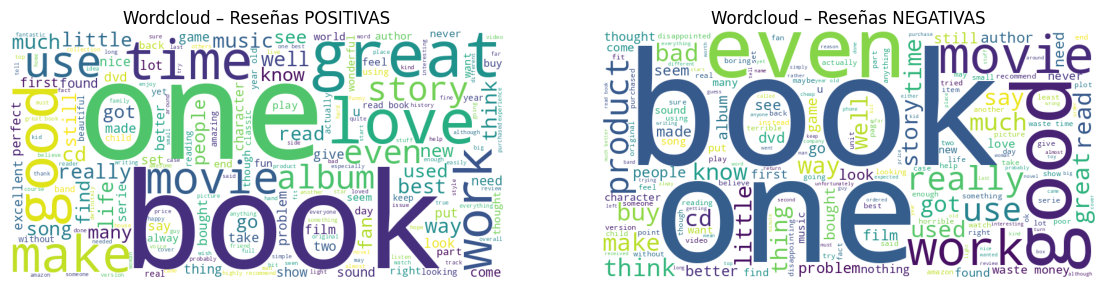

In [9]:
#Se hace el Wordcloud (positivas vs negativas) con una muestra de 50000 para no agotar memoria

sample_pos = df[df.label == 1].sample(50000, random_state=42)["clean_text"]
sample_neg = df[df.label == 0].sample(50000, random_state=42)["clean_text"]

texto_pos = " ".join(sample_pos)
texto_neg = " ".join(sample_neg)

wc_pos = WordCloud(width=800, height=400, background_color="white").generate(texto_pos)
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(texto_neg)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Wordcloud – Reseñas POSITIVAS")

plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Wordcloud – Reseñas NEGATIVAS")

plt.show()

In [10]:
#Para las palabras mas frecuentes
def top_words(series, n=20):
    all_text = " ".join(series)
    counter = Counter(all_text.split())
    return pd.DataFrame(counter.most_common(n), columns=["word","freq"])

top_pos = top_words(sample_pos, n=20)
top_neg = top_words(sample_neg, n=20)

print("Top palabras POSITIVAS:")
display(top_pos)

print("\nTop palabras NEGATIVAS:")
display(top_neg)

Top palabras POSITIVAS:


,word,freq
0,book,31925
1,great,23217
2,not,19678
3,one,19192
4,good,16671
5,like,13962
6,love,11524
7,read,11203
8,time,11066
9,well,9833



Top palabras NEGATIVAS:


,word,freq
0,not,45701
1,book,30261
2,one,20368
3,like,15337
4,would,14460
5,no,12668
6,time,12377
7,good,12332
8,get,12285
9,don't,11105


In [11]:
# Se lleva a cabo la Vectorización TF-IDF

df[["reviewText", "clean_text"]].head()
# importamos TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Con el dataset completo, es mejor limitar el vocabulario.

vectorizer = TfidfVectorizer(
    max_features=2500,      # hasta 2500 términos
    ngram_range=(1,1),       # unigramas porque con bigramas debido al peso de come toda la RAM
    min_df=20,                # aparece al menos en 20 documentos
    dtype=np.float32
)

X = vectorizer.fit_transform(df["clean_text"])
y = df["label"].values

X.shape

(4000000, 2500)

In [12]:
#Guardamos los datos procesados
# Datos limpios en CSV
df.to_csv("amazon_bittlingmayer_clean.csv", index=False)

# Matriz TF-IDF + vectorizador + etiquetas para usar despues en modelos
with open("amazon_bittlingmayer_tfidf.pkl", "wb") as f:
    pickle.dump((X, y, vectorizer), f)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


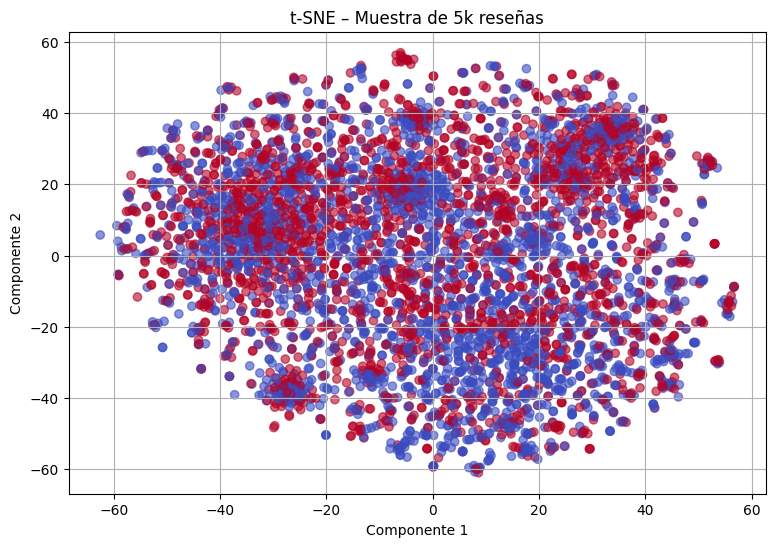

In [14]:
#Aplicamos el t-SNE sobre una muestra de 5000 para la visualización

N = 5000
df_tsne = df.sample(N, random_state=42)
X_tsne = vectorizer.transform(df_tsne["clean_text"])
y_tsne = df_tsne["label"].values

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
X_emb = tsne.fit_transform(X_tsne.toarray())

plt.scatter(X_emb[:,0], X_emb[:,1], c=y_tsne, cmap="coolwarm", alpha=0.6)
plt.title("t-SNE – Muestra de 5k reseñas")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

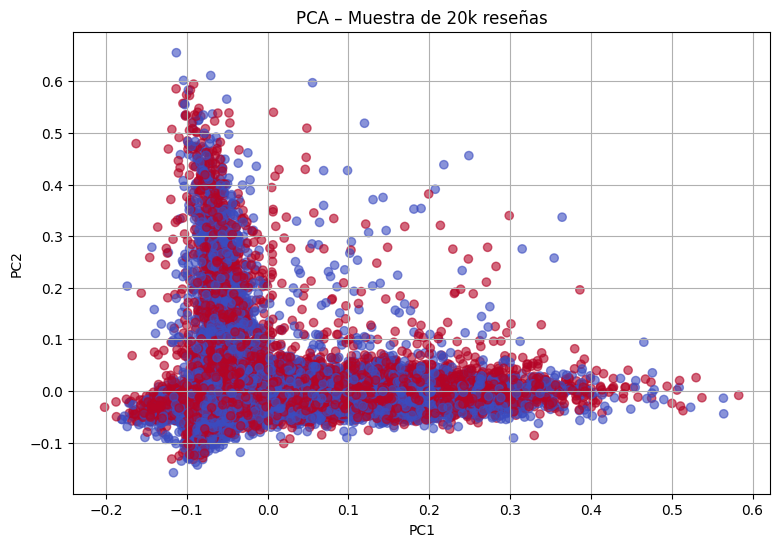

In [15]:
#Y el PCA con una muestra un poco mas grande
N = 20000
df_pca = df.sample(N, random_state=123)
X_pca_m = vectorizer.transform(df_pca["clean_text"])
y_pca_m = df_pca["label"].values

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pca_m.toarray())

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pca_m, cmap="coolwarm", alpha=0.6)
plt.title("PCA – Muestra de 20k reseñas")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()